In [ ]:
# Cell 1: Imports and Setup
%matplotlib inline
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Masking
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pickle
import re
import glob

# Parameters
FRAME_WIDTH = 224
FRAME_HEIGHT = 224
FRAMES_PER_VIDEO = 20
NUM_CONSIDERED_FRAMES = 100
FEATURE_SHAPE = (1280,)
FRAME_STEP = 5  # Extract every 5th frame from considered frames
DATASET_PATH = 'dataset'
FRAME_DIR = 'extracted_frames'
FEATURE_DIR = 'features'
CSV_DIR = 'csv_files'

# Label corrections
LABEL_CORRECTIONS = {
    'Threatning using object': 'Threatening using object',
    'Threatning using objects': 'Threatening using object',
    'Wemen surrounded by men': 'Women surrounded by men',
}

def clean_labels(label):
    return LABEL_CORRECTIONS.get(label.strip(), label.strip())

def sanitize_filename(name):
    """Replace invalid characters in filenames with '_'."""
    return re.sub(r'[^\w\-_\.]', '_', name)

def verify_dataset():
    """Check if dataset contains valid videos."""
    video_extensions = ('.mp4', '.avi', '.mov')
    video_count = 0
    for root, _, files in os.walk(DATASET_PATH):
        for f in files:
            if f.lower().endswith(video_extensions):
                video_path = os.path.join(root, f)
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened() or cap.get(cv2.CAP_PROP_FRAME_COUNT) == 0:
                    print(f"⚠️ Corrupted or empty video: {video_path}")
                else:
                    video_count += 1
                cap.release()
    if video_count == 0:
        raise ValueError(f"No valid videos found in {DATASET_PATH}")
    print(f"✅ Found {video_count} valid videos in {DATASET_PATH}")
    return video_count

# Clear output directories
def clear_output_dirs():
    for d in [CSV_DIR, FRAME_DIR, FEATURE_DIR]:
        if os.path.exists(d):
            for root, dirs, files in os.walk(d, topdown=False):
                for f in files:
                    os.remove(os.path.join(root, f))
                for dir in dirs:
                    os.rmdir(os.path.join(root, dir))
            os.rmdir(d)
    print("✅ Cleared output directories")

# Execute
clear_output_dirs()
verify_dataset()
print("✅ Setup complete")

In [19]:
# Cell 2: Collect Video Paths and Create Train/Test Split
def get_video_paths(data_dir):
    videos = []
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    for category in categories:
        category_path = os.path.join(data_dir, category)
        video_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
        for video in video_files:
            video_path = os.path.join(category_path, video)
            cleaned_category = clean_labels(category)
            videos.append((cleaned_category, video_path))
    
    return videos

def create_train_test_csv():
    videos = get_video_paths(DATASET_PATH)
    if not videos:
        raise ValueError("No videos found in dataset. Check DATASET_PATH and file formats.")
    
    df = pd.DataFrame(videos, columns=['tag', 'video_name'])
    
    # 80-20 train-test split, stratified by category
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['tag'], random_state=42)
    
    os.makedirs(CSV_DIR, exist_ok=True)
    train_df.to_csv(os.path.join(CSV_DIR, 'train.csv'), index=False)
    test_df.to_csv(os.path.join(CSV_DIR, 'test.csv'), index=False)
    
    print(f"✅ Created train.csv ({len(train_df)} videos) and test.csv ({len(test_df)} videos)")
    print("Activity categories:", df['tag'].unique())
    return train_df, test_df

# Execute
train_df, test_df = create_train_test_csv()
train_df.head()

✅ Created train.csv (484 videos) and test.csv (121 videos)
Activity categories: ['Abuse:Assault:Violence:Fight' 'Threatening using object'
 'women surrounded by men' 'Chasing:stalking:snatching' 'Normal']


,tag,video_name
422,Chasing:stalking:snatching,dataset/Chasing:stalking:snatching/17 copy.mp4
137,Abuse:Assault:Violence:Fight,dataset/Abuse:Assault:Violence:Fight/Pennsylva...
562,Normal,dataset/Normal/Normal_Videos_696_x264.mp4
219,Abuse:Assault:Violence:Fight,dataset/Abuse:Assault:Violence:Fight/Abuse001_...
147,Abuse:Assault:Violence:Fight,dataset/Abuse:Assault:Violence:Fight/kJ438wnqK...


In [20]:
# Cell 3: Frame Extraction
def extract_uniform_frames(video_path, num_frames=FRAMES_PER_VIDEO, considered_frames=NUM_CONSIDERED_FRAMES):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Cannot open video: {video_path}")
        return []
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames == 0:
        print(f"⚠️ Skipping empty video: {video_path}")
        cap.release()
        return []
    
    # Select ~100 frames (or fewer) uniformly
    if total_frames < considered_frames:
        step = 1
        considered_indices = list(range(total_frames))
    else:
        step = total_frames / considered_frames
        considered_indices = [int(i * step) for i in range(considered_frames)]
    
    # From considered frames, select every 5th frame to get 20 frames
    selected_indices = considered_indices[::FRAME_STEP][:num_frames]
    if len(selected_indices) < num_frames:
        print(f"⚠️ Warning: {video_path} has only {len(selected_indices)} frames after selection.")
    
    frames = []
    for idx in selected_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (FRAME_WIDTH, FRAME_HEIGHT))
            frames.append(frame)
        else:
            print(f"❌ Failed to read frame {idx} in {video_path}")
    
    cap.release()
    print(f"✅ Extracted {len(frames)} frames from {video_path}")
    return frames

def extract_frames_to_disk(csv_path, dataset_type):
    df = pd.read_csv(csv_path)
    base_dir = os.path.join(FRAME_DIR, dataset_type)
    os.makedirs(base_dir, exist_ok=True)
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Extracting {dataset_type} frames"):
        tag = sanitize_filename(row['tag'])
        video_path = row['video_name']
        video_id = sanitize_filename(os.path.splitext(os.path.basename(video_path))[0])
        output_dir = os.path.join(base_dir, tag, video_id)
        os.makedirs(output_dir, exist_ok=True)
        
        frames = extract_uniform_frames(video_path)
        if not frames:
            continue
        
        for i, frame in enumerate(frames):
            save_path = os.path.join(output_dir, f"frame_{i}.jpg")
            cv2.imwrite(save_path, frame)
            if not os.path.exists(save_path):
                print(f"❌ Failed to save frame: {save_path}")
            else:
                print(f"✅ Saved frame: {save_path}")
    
    print(f"✅ Completed frame extraction for {dataset_type} set")
    # Verify frames
    frame_count = 0
    for root, _, files in os.walk(base_dir):
        frame_count += len([f for f in files if f.endswith(('.jpg', '.png'))])
    print(f"Total frames saved for {dataset_type}: {frame_count}")
    if frame_count == 0:
        print(f"⚠️ No frames saved for {dataset_type}. Check video files and permissions.")

# Execute
extract_frames_to_disk(os.path.join(CSV_DIR, 'train.csv'), 'train')
extract_frames_to_disk(os.path.join(CSV_DIR, 'test.csv'), 'test')

Extracting train frames:   0%|          | 0/484 [00:00<?, ?it/s]

✅ Extracted 20 frames from dataset/Chasing:stalking:snatching/17 copy.mp4
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/frame_0.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/frame_1.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/frame_2.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/frame_3.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/frame_4.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/frame_5.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/frame_6.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/frame_7.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/frame_8.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/frame_9.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/17_copy/fra

[h264 @ 0x31d548b30] mmco: unref short failure


✅ Extracted 20 frames from dataset/Chasing:stalking:snatching/How Inside Edition Helped Catch These ‘Smash and Grab’ Thieves.mp4
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/How_Inside_Edition_Helped_Catch_These__Smash_and_Grab__Thieves/frame_0.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/How_Inside_Edition_Helped_Catch_These__Smash_and_Grab__Thieves/frame_1.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/How_Inside_Edition_Helped_Catch_These__Smash_and_Grab__Thieves/frame_2.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/How_Inside_Edition_Helped_Catch_These__Smash_and_Grab__Thieves/frame_3.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/How_Inside_Edition_Helped_Catch_These__Smash_and_Grab__Thieves/frame_4.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/How_Inside_Edition_Helped_Catch_These__Smash_and_Grab__Thieves/frame_5.jpg
✅ Saved frame: extracted_frames

[h264 @ 0x319518bf0] mmco: unref short failure


✅ Extracted 20 frames from dataset/Chasing:stalking:snatching/This Is What Happened When a Purse With Money Was Left Unattended.mp4
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/This_Is_What_Happened_When_a_Purse_With_Money_Was_Left_Unattended/frame_0.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/This_Is_What_Happened_When_a_Purse_With_Money_Was_Left_Unattended/frame_1.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/This_Is_What_Happened_When_a_Purse_With_Money_Was_Left_Unattended/frame_2.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/This_Is_What_Happened_When_a_Purse_With_Money_Was_Left_Unattended/frame_3.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/This_Is_What_Happened_When_a_Purse_With_Money_Was_Left_Unattended/frame_4.jpg
✅ Saved frame: extracted_frames/train/Chasing_stalking_snatching/This_Is_What_Happened_When_a_Purse_With_Money_Was_Left_Unattended/frame_5.jpg
✅ Saved fr

Extracting test frames:   0%|          | 0/121 [00:00<?, ?it/s]

✅ Extracted 20 frames from dataset/Threatning using objects/11.mp4
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_0.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_1.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_2.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_3.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_4.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_5.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_6.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_7.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_8.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_9.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_10.jpg
✅ Saved frame: extracted_frames/test/Threatening_using_object/11/frame_11.jpg
✅ Saved

In [21]:
# Cell 4: Feature Extraction with MobileNetV2
def extract_features(dataset_type):
    model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
    root_dir = os.path.join(FRAME_DIR, dataset_type)
    save_dir = os.path.join(FEATURE_DIR, dataset_type)
    os.makedirs(save_dir, exist_ok=True)
    
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"Frame directory {root_dir} does not exist. Check frame extraction.")
    
    feature_count = 0
    for class_name in tqdm(os.listdir(root_dir), desc=f"Processing {dataset_type} features"):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        class_save_dir = os.path.join(save_dir, class_name)
        os.makedirs(class_save_dir, exist_ok=True)
        
        for video_folder in os.listdir(class_path):
            frame_folder = os.path.join(class_path, video_folder)
            if not os.path.isdir(frame_folder):
                continue
            
            frame_files = sorted([f for f in os.listdir(frame_folder) if f.lower().endswith(('.jpg', '.png'))])
            print(f"Processing {frame_folder}: Found {len(frame_files)} frames")
            
            if len(frame_files) < FRAMES_PER_VIDEO:
                print(f"⚠️ Skipping {frame_folder}: Expected {FRAMES_PER_VIDEO} frames, found {len(frame_files)}")
                continue
            
            feature_list = []
            for frame_file in frame_files:
                frame_path = os.path.join(frame_folder, frame_file)
                try:
                    img = image.load_img(frame_path, target_size=(224, 224))
                    img_array = image.img_to_array(img)
                    img_array = preprocess_input(img_array)
                    feature_list.append(img_array)
                except Exception as e:
                    print(f"❌ Error processing {frame_path}: {e}")
                    break
            
            if len(feature_list) != FRAMES_PER_VIDEO:
                print(f"⚠️ Skipping {frame_folder}: Processed only {len(feature_list)} frames")
                continue
            
            frames_array = np.array(feature_list)
            try:
                # Process in batches to reduce memory usage
                batch_size = 5
                features = []
                for i in range(0, len(frames_array), batch_size):
                    batch = frames_array[i:i+batch_size]
                    batch_features = model.predict(batch, verbose=0)
                    features.append(batch_features)
                features = np.concatenate(features)
                
                feature_path = os.path.join(class_save_dir, f"{video_folder}.npy")
                np.save(feature_path, features)
                if os.path.exists(feature_path):
                    print(f"✅ Saved features: {feature_path} (Shape: {features.shape})")
                    feature_count += 1
                else:
                    print(f"❌ Failed to save feature file: {feature_path}")
            except Exception as e:
                print(f"❌ Error during feature extraction for {frame_folder}: {e}")
    
    print(f"✅ Completed feature extraction for {dataset_type} set")
    print(f"Total feature files saved for {dataset_type}: {feature_count}")
    if feature_count == 0:
        print(f"⚠️ No feature files saved for {dataset_type}. Check frame files and extraction process.")

# Execute
extract_features('train')
extract_features('test')

Processing train features:   0%|          | 0/5 [00:00<?, ?it/s]

Processing extracted_frames/train/Abuse_Assault_Violence_Fight/PhillyCrimeUpdate_on_X-_-WATCH-_Vicious_random_attack_on_3_women_in_South_Philly_last_night.__Philadelphia__PhillyCrimeUpdate_https-__t.co_ZfUrWVBrFW-___X: Found 20 frames


2025-04-20 18:11:08.698305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


✅ Saved features: features/train/Abuse_Assault_Violence_Fight/PhillyCrimeUpdate_on_X-_-WATCH-_Vicious_random_attack_on_3_women_in_South_Philly_last_night.__Philadelphia__PhillyCrimeUpdate_https-__t.co_ZfUrWVBrFW-___X.npy (Shape: (20, 1280))
Processing extracted_frames/train/Abuse_Assault_Violence_Fight/Watch_Florida_woman_fights_off_gym_attacker: Found 20 frames
✅ Saved features: features/train/Abuse_Assault_Violence_Fight/Watch_Florida_woman_fights_off_gym_attacker.npy (Shape: (20, 1280))
Processing extracted_frames/train/Abuse_Assault_Violence_Fight/50: Found 20 frames
✅ Saved features: features/train/Abuse_Assault_Violence_Fight/50.npy (Shape: (20, 1280))
Processing extracted_frames/train/Abuse_Assault_Violence_Fight/ab4: Found 20 frames
✅ Saved features: features/train/Abuse_Assault_Violence_Fight/ab4.npy (Shape: (20, 1280))
Processing extracted_frames/train/Abuse_Assault_Violence_Fight/J8MbPP2GXegFlSlE_copy: Found 20 frames
✅ Saved features: features/train/Abuse_Assault_Violence_F

Processing test features:   0%|          | 0/5 [00:00<?, ?it/s]

Processing extracted_frames/test/Abuse_Assault_Violence_Fight/ab3: Found 20 frames
✅ Saved features: features/test/Abuse_Assault_Violence_Fight/ab3.npy (Shape: (20, 1280))
Processing extracted_frames/test/Abuse_Assault_Violence_Fight/Fighting018_x264: Found 20 frames
✅ Saved features: features/test/Abuse_Assault_Violence_Fight/Fighting018_x264.npy (Shape: (20, 1280))
Processing extracted_frames/test/Abuse_Assault_Violence_Fight/7_copy: Found 20 frames
✅ Saved features: features/test/Abuse_Assault_Violence_Fight/7_copy.npy (Shape: (20, 1280))
Processing extracted_frames/test/Abuse_Assault_Violence_Fight/21_copy: Found 20 frames
✅ Saved features: features/test/Abuse_Assault_Violence_Fight/21_copy.npy (Shape: (20, 1280))
Processing extracted_frames/test/Abuse_Assault_Violence_Fight/37_copy: Found 20 frames
✅ Saved features: features/test/Abuse_Assault_Violence_Fight/37_copy.npy (Shape: (20, 1280))
Processing extracted_frames/test/Abuse_Assault_Violence_Fight/CCTV_footage_-_Brave_teenagers

In [22]:
# Cell 5: Load Sequences and Prepare Data
def load_sequences(csv_path, feature_folder, max_seq_len):
    df = pd.read_csv(csv_path)
    X, y = [], []
    
    for _, row in df.iterrows():
        video_path = row['video_name']
        label = row['tag']
        video_id = sanitize_filename(os.path.splitext(os.path.basename(video_path))[0])
        class_name = sanitize_filename(clean_labels(os.path.basename(os.path.dirname(video_path))))
        feature_path = os.path.join(FEATURE_DIR, feature_folder, class_name, f"{video_id}.npy")
        
        if os.path.exists(feature_path):
            features = np.load(feature_path)
            if features.shape[0] == FRAMES_PER_VIDEO:
                X.append(features)
                y.append(label)
                print(f"✅ Loaded feature: {feature_path}")
            else:
                print(f"⚠️ Skipping {feature_path}: Expected {FRAMES_PER_VIDEO} frames, found {features.shape[0]}")
        else:
            print(f"⚠️ Missing feature file: {feature_path}")
    
    if not X:
        raise ValueError(f"No valid feature files loaded for {feature_folder}. Check feature extraction.")
    
    X_padded = pad_sequences(X, maxlen=max_seq_len, dtype='float32', padding='post')
    return np.array(X_padded), np.array(y)

def get_max_sequence_length(csv_path, feature_folder):
    df = pd.read_csv(csv_path)
    max_len = 0
    for _, row in df.iterrows():
        video_path = row['video_name']
        video_id = sanitize_filename(os.path.splitext(os.path.basename(video_path))[0])
        class_name = sanitize_filename(clean_labels(os.path.basename(os.path.dirname(video_path))))
        feature_path = os.path.join(FEATURE_DIR, feature_folder, class_name, f"{video_id}.npy")
        if os.path.exists(feature_path):
            features = np.load(feature_path)
            max_len = max(max_len, features.shape[0])
    if max_len == 0:
        raise ValueError(f"No feature files found for {feature_folder}. Check feature extraction.")
    return max_len

# Execute
try:
    max_seq_len = get_max_sequence_length(os.path.join(CSV_DIR, 'train.csv'), 'train')
    X_train_seq, y_train_seq = load_sequences(os.path.join(CSV_DIR, 'train.csv'), 'train', max_seq_len)
    X_test_seq, y_test_seq = load_sequences(os.path.join(CSV_DIR, 'test.csv'), 'test', max_seq_len)
    print(f"✅ X_train_seq shape: {X_train_seq.shape}")
    print(f"✅ y_train_seq shape: {y_train_seq.shape}")
    print(f"✅ X_test_seq shape: {X_test_seq.shape}")
    print(f"✅ y_test_seq shape: {y_test_seq.shape}")
except ValueError as e:
    print(f"❌ Error: {e}")

✅ Loaded feature: features/train/Chasing_stalking_snatching/17_copy.npy
✅ Loaded feature: features/train/Abuse_Assault_Violence_Fight/Pennsylvania_baseball_player_cut_over_domestic_abuse_video.npy
✅ Loaded feature: features/train/Normal/Normal_Videos_696_x264.npy
✅ Loaded feature: features/train/Abuse_Assault_Violence_Fight/Abuse001_x264.npy
✅ Loaded feature: features/train/Abuse_Assault_Violence_Fight/kJ438wnqKU_0i-mq.npy
✅ Loaded feature: features/train/Abuse_Assault_Violence_Fight/49.npy
✅ Loaded feature: features/train/Normal/Normal_Videos_879_x264.npy
✅ Loaded feature: features/train/Chasing_stalking_snatching/8.npy
✅ Loaded feature: features/train/Normal/Normal_Videos_312_x264.npy
✅ Loaded feature: features/train/Abuse_Assault_Violence_Fight/A.npy
✅ Loaded feature: features/train/women_surrounded_by_men/12.npy
✅ Loaded feature: features/train/Abuse_Assault_Violence_Fight/iIzgLqx0VvPeZ07I.npy
✅ Loaded feature: features/train/Abuse_Assault_Violence_Fight/26_copy.npy
✅ Loaded featur

In [23]:
# Cell 6: Train the Model
def train_model(X_train, y_train, X_test, y_test, num_classes):
    tf.keras.backend.clear_session()
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Save label encoder
    with open("label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)
    
    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
    class_weights_dict = dict(enumerate(class_weights))
    
    # Build model
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
        Bidirectional(LSTM(128, return_sequences=False)),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train
    history = model.fit(
        X_train, y_train_encoded,
        validation_data=(X_test, y_test_encoded),
        epochs=40,
        batch_size=8,
        class_weight=class_weights_dict,
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history, label_encoder, y_train_encoded, y_test_encoded

# Execute
num_classes = len(set(y_train_seq))
model, history, label_encoder, y_train_encoded, y_test_encoded = train_model(
    X_train_seq, y_train_seq, X_test_seq, y_test_seq, num_classes
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 20, 1280)          0         
                                                                 
 bidirectional (Bidirection  (None, 256)               1442816   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                        

2025-04-20 21:44:24.114762: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2025-04-20 21:44:24.589831: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_40/output/_23'


61/61 [==============================] - 9s 63ms/step - loss: 1.3443 - accuracy: 0.4689 - val_loss: 0.9927 - val_accuracy: 0.6833
Epoch 2/40
61/61 [==============================] - 2s 32ms/step - loss: 0.6786 - accuracy: 0.7469 - val_loss: 0.7913 - val_accuracy: 0.7500
Epoch 3/40
61/61 [==============================] - 2s 31ms/step - loss: 0.3809 - accuracy: 0.8548 - val_loss: 0.5148 - val_accuracy: 0.8167
Epoch 4/40
61/61 [==============================] - 2s 34ms/step - loss: 0.2340 - accuracy: 0.9108 - val_loss: 0.5209 - val_accuracy: 0.7917
Epoch 5/40
61/61 [==============================] - 2s 31ms/step - loss: 0.1446 - accuracy: 0.9523 - val_loss: 0.4157 - val_accuracy: 0.8667
Epoch 6/40
61/61 [==============================] - 2s 31ms/step - loss: 0.1017 - accuracy: 0.9710 - val_loss: 0.3467 - val_accuracy: 0.9000
Epoch 7/40
61/61 [==============================] - 2s 31ms/step - loss: 0.0959 - accuracy: 0.9544 - val_loss: 0.2946 - val_accuracy: 0.9083
Epoch 8/40
61/61 [======

🎯 Test Accuracy: 0.9333


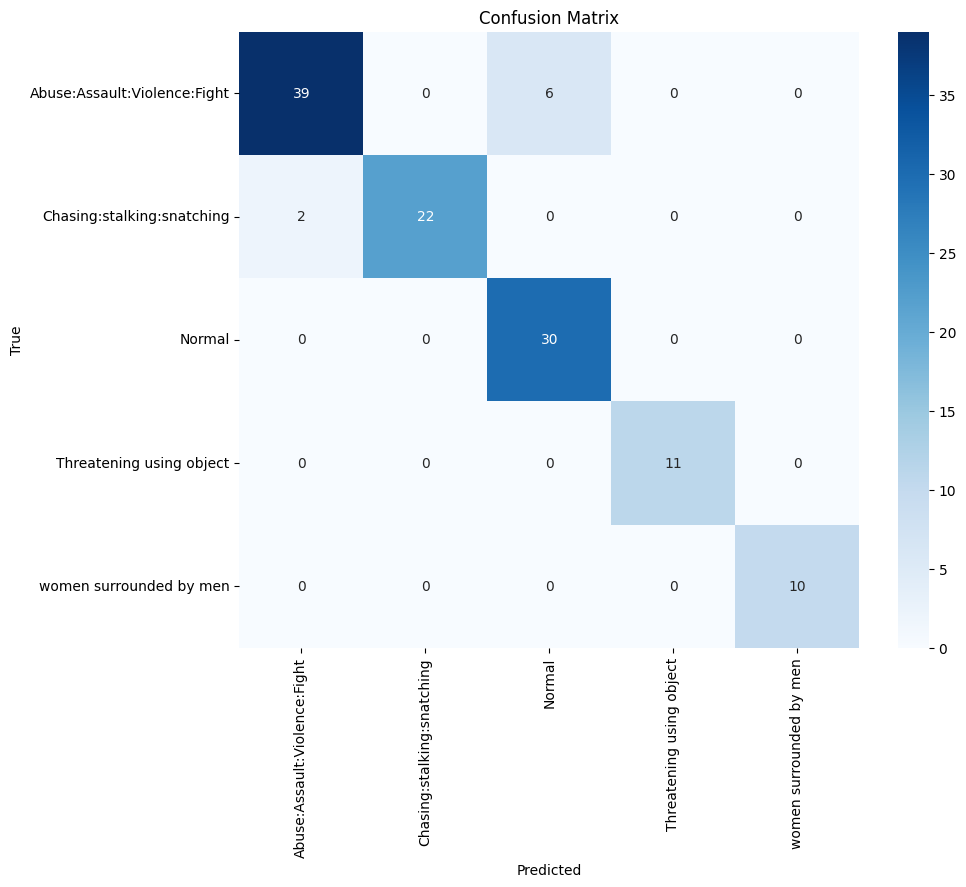


Classification Report:
                              precision    recall  f1-score   support

Abuse:Assault:Violence:Fight       0.95      0.87      0.91        45
  Chasing:stalking:snatching       1.00      0.92      0.96        24
                      Normal       0.83      1.00      0.91        30
    Threatening using object       1.00      1.00      1.00        11
     women surrounded by men       1.00      1.00      1.00        10

                    accuracy                           0.93       120
                   macro avg       0.96      0.96      0.95       120
                weighted avg       0.94      0.93      0.93       120



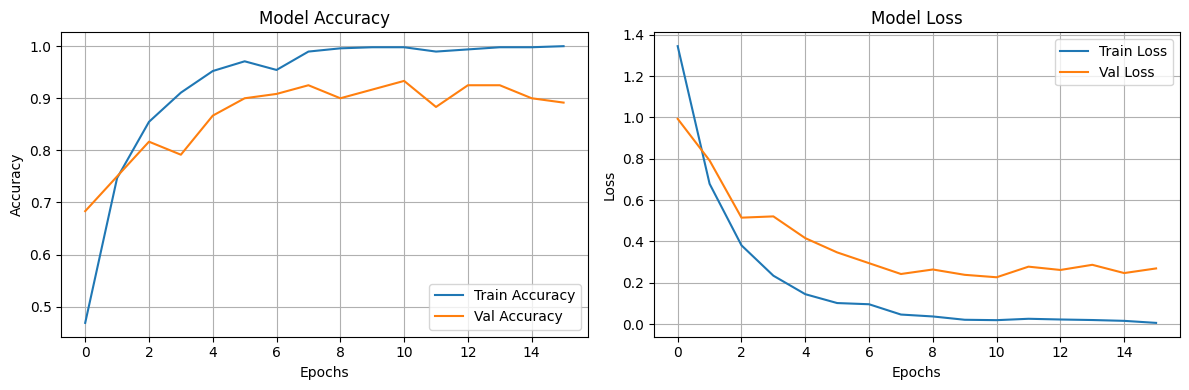

In [24]:
# Cell 7: Evaluate and Plot Results
def evaluate_and_plot(model, history, X_test, y_test_encoded, label_encoder):
    # Test evaluation
    test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=0)
    print(f"🎯 Test Accuracy: {test_acc:.4f}")
    
    # Confusion matrix and classification report
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))
    
    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Execute
evaluate_and_plot(model, history, X_test_seq, y_test_encoded, label_encoder)

In [25]:
# Cell 8: Save Model and Predict New Video
def predict_video_class(video_path, model, label_encoder, max_seq_len):
    mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
    
    frames = extract_uniform_frames(video_path)
    if not frames:
        return None
    
    feature_list = []
    for frame in frames:
        img_array = image.img_to_array(frame)
        img_array = preprocess_input(img_array)
        feature_list.append(img_array)
    
    frames_array = np.array(feature_list)
    features = mobilenet_model.predict(frames_array, verbose=0)
    features_padded = pad_sequences([features], maxlen=max_seq_len, dtype='float32', padding='post')
    
    prediction = model.predict(features_padded, verbose=0)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]
    
    print(f"🎬 Predicted Class for {os.path.basename(video_path)}: {predicted_label}")
    return predicted_label

# Save model
model.save("lstm_video_classifier.h5")
print("✅ Model saved as lstm_video_classifier.h5")

# Example prediction
sample_video = "/Users/yashpagar/Desktop/video_classification_env/custom_video_classifier/dataset/train/Assault/37.mp4"  # Replace with actual path
if os.path.exists(sample_video):
    predict_video_class(sample_video, model, label_encoder, max_seq_len)
else:
    print("⚠️ Sample video not found. Please update the path.")

/Users/yashpagar/Documents/video_classification_env/myvenv/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Model saved as lstm_video_classifier.h5
✅ Extracted 20 frames from /Users/yashpagar/Desktop/video_classification_env/custom_video_classifier/dataset/train/Assault/37.mp4
🎬 Predicted Class for 37.mp4: Abuse:Assault:Violence:Fight
